# Descriptive Plots 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from datetime import datetime
%matplotlib inline
import matplotlib
from datetime import datetime
import os
from scipy import stats

from definitions import HUMAN_DATA_DIR, ROOT_DIR
from data.load_from_csv import get_content_datasets

cmap = matplotlib.cm.Greys
cmap.set_bad('#e8d0a1')

pd.set_option('display.max_rows', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = [40, 8]

In [32]:
def set_small_canvas():
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.rcParams["figure.figsize"] = [15, 10]
    SMALL_SIZE = 20
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 30

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('lines', linewidth=2)


def plot_quick_slow_correlation(train_dataset, x='fast', y='slow'):
    """
    Takes a dataset, plots a graph showing the correlation between 
    judgments.
    
    x: either 'fast', 'medium', or 'slow'
    y: either 'fast', 'medium', or 'slow'
    
    """
    xy_dict = {'fast': 0, 'medium': 1, 'slow': 2}
    # First we strip away the ratings which correspond to slow judgments
    # In the test set.
    ratings = train_dataset.ratings[:]
    non_full_train_indices = []
    for i in range(len(ratings)):
        if np.isnan(ratings[i, 2]):
            non_full_train_indices.append(i)
    ratings = np.delete(ratings, non_full_train_indices, axis=0)

    x_judgments = ratings[:, xy_dict[x]]
    y_judgments = ratings[:, xy_dict[y]]

    xy_pairs = zip(x_judgments, y_judgments)
    xy_pairs_count = {}
    for xy_pair in xy_pairs:
        if xy_pair not in xy_pairs_count:
            xy_pairs_count[xy_pair] = 0
        else:
            xy_pairs_count[xy_pair] += 1
            
    xs = list(zip(*list(xy_pairs_count)))[0]
    ys = list(zip(*list(xy_pairs_count)))[1]
    counts = list(xy_pairs_count.values())

    counts = [3 * z for z in counts]

    fig, ax = plt.subplots()
    ax.scatter(xs, ys, alpha=0.8, s=counts, c='C9')
    ax.set_xlabel(x.title() + ' Judgment')
    ax.set_ylabel(y.title() + ' Judgment')
    

def calculate_correlations(train_dataset, x='fast', y='slow'):
    """
    Takes a dataset, calculates the correlation between judgments.
    
    x: either 'fast', 'medium', or 'slow'
    y: either 'fast', 'medium', or 'slow'
    
    """
    xy_dict = {'fast': 0, 'medium': 1, 'slow': 2}
    # First we strip away the ratings which correspond to slow judgments
    # In the test set.
    ratings = train_dataset.ratings[:]
    non_full_train_indices = []
    for i in range(len(ratings)):
        if np.isnan(ratings[i, 2]):
            non_full_train_indices.append(i)
    ratings = np.delete(ratings, non_full_train_indices, axis=0)
    
    x = ratings[:, xy_dict[x]]
    y = ratings[:, xy_dict[y]]
    
    A = np.vstack([x, np.ones(len(x))]).T
    coefs, residuals, rank, s = np.linalg.lstsq(A, y)
    mean_mse = residuals / len(x)
    r = scipy.stats.linregress(x, y)[2]
    _coefs = scipy.stats.linregress(x, y)[:2]
    print("Correlation coefficient was {:.3f}, mean mse was {:.3f}, coefs are {}".format(float(r), float(mean_mse), _coefs))
    return _coefs

def predict_corrected_fast(test_dataset, train_dataset):
    _coefs = calculate_correlations(train_dataset, 'fast', 'slow')
    # Very inefficient baseline
    test_dataset_ratings = test_dataset.ratings[:] #copy
    for i in range(len(train_dataset.user_ids)):
        for j in range(len(test_dataset.user_ids)):
            if (test_dataset.user_ids[j] == train_dataset.user_ids[i]
                and test_dataset.item_ids[j] == train_dataset.item_ids[i]):
                test_dataset_ratings[j, 0] = train_dataset.ratings[i, 0]

    total_score = 0
    mean_slow = 0
    slow_count = 0
    for rating in train_dataset.ratings:
        if not np.isnan(rating[2]):
            mean_slow += rating[2]
            slow_count += 1
    mean_slow = mean_slow / slow_count
    
    for rating in test_dataset_ratings:
        if np.isnan(rating[0]):
            total_score += (rating[2] - mean_slow)**2
        else:
            total_score += (rating[2] - (_coefs[1] + _coefs[0]*rating[0]))**2
    mean_mse = total_score / len(test_dataset_ratings)
    print("Using predict_fast, got total test score {:.3f}".format(mean_mse))
    return

def predict_fast(test_dataset, train_dataset):
    # Very inefficient baseline
    test_dataset_ratings = test_dataset.ratings[:] #copy
    for i in range(len(train_dataset.user_ids)):
        for j in range(len(test_dataset.user_ids)):
            if (test_dataset.user_ids[j] == train_dataset.user_ids[i]
                and test_dataset.item_ids[j] == train_dataset.item_ids[i]):
                test_dataset_ratings[j, 0] = train_dataset.ratings[i, 0]

    total_score = 0
    mean_slow = 0
    slow_count = 0
    for rating in train_dataset.ratings:
        if not np.isnan(rating[2]):
            mean_slow += rating[2]
            slow_count += 1
    mean_slow = mean_slow / slow_count
    
    for rating in test_dataset_ratings:
        if np.isnan(rating[0]):
            total_score += (rating[2] - mean_slow)**2
        else:
            total_score += (rating[2] - rating[0])**2
    mean_mse = total_score / len(test_dataset_ratings)
    print("Using predict_fast, got total val score {:.3f}".format(mean_mse))
    return


        
def mean_quantile_all_data(dataset, answers, err = 'std'):
    set_small_canvas()
    dataset.answers = answers
    num_users = len(np.unique(dataset.user_ids))

    user_true_ratings_dict = {iid: 0 for iid in np.unique(dataset.user_ids)}
    user_false_ratings_dict = {iid: 0 for iid in np.unique(dataset.user_ids)}

    user_time_true_ratings_dict = {(iid, i): 0 for iid in np.unique(dataset.user_ids) for i in range(3)}
    user_time_false_ratings_dict = {(iid, i): 0 for iid in np.unique(dataset.user_ids) for i in range(3)}

    for index, triple_rating in enumerate(dataset.ratings):
        item_id = dataset.item_ids[index]
        user_id = dataset.user_ids[index]
        for time, rating in enumerate(triple_rating):
            if rating > 0.5 and dataset.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
                user_time_true_ratings_dict[user_id, time] += 1
            elif rating < 0.5 and dataset.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
                user_time_false_ratings_dict[user_id, time] += 1
            elif rating < 0.5 and not dataset.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
                user_time_true_ratings_dict[user_id, time] += 1            
            elif rating > 0.5 and not dataset.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
                user_time_false_ratings_dict[user_id, time] += 1            

    correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(dataset.user_ids)
                   if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 0}

    correct_time_fracs = {(u, i): user_time_true_ratings_dict[(u, i)] / (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) for u in np.unique(dataset.user_ids)
                       for i in range(3) if (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) > 0}

    correct_frac_list = [[u, frac] for u, frac in correct_frac.items()]
    correct_frac_list.sort(key=lambda x: x[1])
    user_subsets = []
    fig, ax = plt.subplots()  
    n_splits = 3
    labels = ['Worst third of users', 'Medium third of users', 'Best third of users']
    fmt = ['-', '--', '-.']
    colors = ['C9', 'C1','C3']
    for i in range(n_splits):
        users = list(zip(*correct_frac_list[i*num_users//n_splits:(i+1)*num_users//n_splits]))[0]
        accs = [np.mean([correct_time_fracs[u, i] for u in users if (u,i) in correct_time_fracs.keys()]) for i in [0, 1, 2]]
        if err == 'std':
            stds = [np.std([correct_time_fracs[u, i] for u in users if (u,i) in correct_time_fracs.keys()]) for i in [0, 1, 2]]
        elif err == 'sem':
            stds = [stats.sem([correct_time_fracs[u, i] for u in users if (u,i) in correct_time_fracs.keys()]) for i in [0, 1, 2]]
        ax.errorbar([0+i*0.01, 1+i*0.01, 2+i*0.01], accs, [std for std in stds], fmt=fmt[i],
                    label=labels[i], linewidth=5, capsize=14, capthick=5, color=colors[i])

    best_users = users

    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)      
    ax.set_ylabel('Fraction Correct')
    ax.set_xlabel('Time')
    xticks = ax.get_xticks()
    ax.xaxis.set_ticklabels(['', 'Quick (30s)', '', '', '', 'Medium (90s)', '', '', '', 'Slow (360s)'])
    plt.legend(loc='lower right')
    print("Caption: Performance of users over time, using whole dataset for both binning and mean.")


    plt.savefig(os.path.join(ROOT_DIR, 'results', 'performance_time.pdf'))

    plt.show()
    return best_users

def mean_quantile_subset_data(seed,  df, p=0.5, title='', fil=3):
    set_small_canvas()
    plt.rcParams["figure.figsize"] = [5,5]

    df = df.groupby('user_ids'). filter(lambda x: len(x) > fil)

    first_half_df = df.sample(int(df.shape[0]*p), random_state =seed)
    other_half_df = df[~df.index.isin(first_half_df.index)]

    num_half_fermi_users = len(set(first_half_df.user_ids))


    def make_stuff(half_df):
        user_true_ratings_dict = {iid: 0 for iid in np.unique(half_df.user_ids)}
        user_false_ratings_dict = {iid: 0 for iid in np.unique(half_df.user_ids)}

        user_time_true_ratings_dict = {(iid, i): 0 for iid in np.unique(half_df.user_ids) for i in range(3)}
        user_time_false_ratings_dict = {(iid, i): 0 for iid in np.unique(half_df.user_ids) for i in range(3)}

        for index, triple_rating in zip(half_df.index, half_df.responses.values):
            item_id = half_df.item_ids[index]
            user_id = half_df.user_ids[index]
            for time, rating in enumerate(triple_rating):
                if rating > 0.5 and half_df.answer[index]:
                    user_true_ratings_dict[user_id] += 1
                    user_time_true_ratings_dict[user_id, time] += 1
                elif rating < 0.5 and half_df.answer[index]:
                    user_false_ratings_dict[user_id] += 1
                    user_time_false_ratings_dict[user_id, time] += 1
                elif rating < 0.5 and not half_df.answer[index]:
                    user_true_ratings_dict[user_id] += 1
                    user_time_true_ratings_dict[user_id, time] += 1            
                elif rating > 0.5 and not half_df.answer[index]:
                    user_false_ratings_dict[user_id] += 1
                    user_time_false_ratings_dict[user_id, time] += 1  
                    

        correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(half_df.user_ids)
                       if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 0}

        correct_time_fracs = {(u, i): user_time_true_ratings_dict[(u, i)] / (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) for u in np.unique(half_df.user_ids)
                           for i in range(3) if (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) > 0}
        return correct_frac, correct_time_fracs 

    first_half_correct_frac, first_half_correct_time_fracs = make_stuff(first_half_df)
    other_half_correct_frac, other_half_correct_time_fracs = make_stuff(other_half_df)

    first_half_correct_frac_list = [[u, frac] for u, frac in first_half_correct_frac.items()]
    first_half_correct_frac_list.sort(key=lambda x: x[1])

    other_half_correct_frac_list = [[u, frac] for u, frac in other_half_correct_frac.items()]
    other_half_correct_frac_list.sort(key=lambda x: x[1])

    fermi_user_subsets = []
    fig, ax = plt.subplots()  
    n_splits = 3
    labels = ['Worst third of users', 'Medium third of users', 'Best third of users']
    fmt = ['-', '--', '-.']
    colors = ['C9', 'C1','C3']
    count = 0
    for i in range(n_splits):
        users = list(zip(*first_half_correct_frac_list[i*num_half_fermi_users//n_splits:(i+1)*num_half_fermi_users//n_splits]))[0]
        accs = [np.mean([other_half_correct_time_fracs[u, i] for u in users if (u,i) in other_half_correct_time_fracs.keys()]) for i in [0, 1, 2]]
        stds = [stats.sem([other_half_correct_time_fracs[u, i] for u in users if (u,i) in other_half_correct_time_fracs.keys()]) for i in [0, 1, 2]]
        ax.errorbar([0, 1, 2], accs, [std for std in stds], fmt=fmt[i],
                    label=labels[i], linewidth=5, capsize=14, capthick=3, color=colors[i])

    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)      
    ax.set_ylabel('Fraction Correct')
    ax.set_xlabel('Time')
    xticks = ax.get_xticks()
    ax.xaxis.set_ticklabels(['', 'Quick (30s)', '', '', '', 'Medium (90s)', '', '', '', 'Slow (360s)'])
    plt.title("Fermi, " + title)
 
    plt.show()
    
def mean_quantile_multiple_seeds(n_seeds,  df, p=0.5, title='', fil=3, n_splits = 3, legend=True):
    set_small_canvas()
#     plt.rcParams["figure.figsize"] = [5,5]

    df = df.groupby('user_ids'). filter(lambda x: len(x) > fil)
    
#     n_splits = 3
    scores = np.ones([n_seeds, n_splits, 3], dtype=object)
    for seed in range(n_seeds):

        first_half_df = df.sample(int(df.shape[0]*p), random_state =seed)
        other_half_df = df[~df.index.isin(first_half_df.index)]

        num_half_fermi_users = len(set(first_half_df.user_ids))


        def make_stuff(half_df):
            user_true_ratings_dict = {iid: 0 for iid in np.unique(half_df.user_ids)}
            user_false_ratings_dict = {iid: 0 for iid in np.unique(half_df.user_ids)}

            user_time_true_ratings_dict = {(iid, i): 0 for iid in np.unique(half_df.user_ids) for i in range(3)}
            user_time_false_ratings_dict = {(iid, i): 0 for iid in np.unique(half_df.user_ids) for i in range(3)}

            for index, triple_rating in zip(half_df.index, half_df.responses.values):
                item_id = half_df.item_ids[index]
                user_id = half_df.user_ids[index]
                for time, rating in enumerate(triple_rating):
                    if rating > 0.5 and half_df.answer[index]:
                        user_true_ratings_dict[user_id] += 1
                        user_time_true_ratings_dict[user_id, time] += 1
                    elif rating < 0.5 and half_df.answer[index]:
                        user_false_ratings_dict[user_id] += 1
                        user_time_false_ratings_dict[user_id, time] += 1
                    elif rating < 0.5 and not half_df.answer[index]:
                        user_true_ratings_dict[user_id] += 1
                        user_time_true_ratings_dict[user_id, time] += 1            
                    elif rating > 0.5 and not half_df.answer[index]:
                        user_false_ratings_dict[user_id] += 1
                        user_time_false_ratings_dict[user_id, time] += 1  


            correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(half_df.user_ids)
                           if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 0}

            correct_time_fracs = {(u, i): user_time_true_ratings_dict[(u, i)] / (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) for u in np.unique(half_df.user_ids)
                               for i in range(3) if (user_time_true_ratings_dict[(u, i)] + user_time_false_ratings_dict[(u, i)]) > 0}
            return correct_frac, correct_time_fracs 

        first_half_correct_frac, first_half_correct_time_fracs = make_stuff(first_half_df)
        other_half_correct_frac, other_half_correct_time_fracs = make_stuff(other_half_df)

        first_half_correct_frac_list = [[u, frac] for u, frac in first_half_correct_frac.items()]
        first_half_correct_frac_list.sort(key=lambda x: x[1])

        other_half_correct_frac_list = [[u, frac] for u, frac in other_half_correct_frac.items()]
        other_half_correct_frac_list.sort(key=lambda x: x[1])

        fermi_user_subsets = []
          
        
        labels = ['Worst third of users', 'Medium third of users', 'Best third of users']
        fmt = ['-', '--', '-.']
        colors = ['C9', 'C1','C3']
        count = 0
        accs_list = []
        stds_list = []
        for split in range(n_splits):
            users = list(zip(*first_half_correct_frac_list[split*num_half_fermi_users//n_splits:(split+1)*num_half_fermi_users//n_splits]))[0]
            for time in [0, 1, 2]:
                scores[seed, split, time] = [other_half_correct_time_fracs[u, time] for u in users if (u,time) in other_half_correct_time_fracs.keys()]
    
    mean_split_time = np.zeros([n_splits, 3])
    sem_split_time = np.zeros([n_splits, 3])
    for split in range(n_splits):
        for time in [0, 1, 2]:
            split_time_score_over_seeds = []
            for seed in range(n_seeds):
                split_time_score_over_seeds += scores[seed, split, time]
#                 break
            mean_split_time[split, time] = np.mean(split_time_score_over_seeds)
            sem_split_time[split, time] = stats.sem(split_time_score_over_seeds)
            
    

    fig, ax = plt.subplots()
    for i in range(n_splits):
        plt.plot([0, 1, 2], mean_split_time[i, :], label=labels[i],color=colors[i])
        plt.fill_between([0, 1, 2], mean_split_time[i, :]-sem_split_time[i, :], mean_split_time[i, :]+sem_split_time[i, :], color=colors[i],  alpha = 0.5)
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)      
    ax.set_ylabel('Fraction Correct')
    ax.set_xlabel('Time')
    xticks = ax.get_xticks()
    ax.xaxis.set_ticklabels(['', 'Quick (30s)', '', '', '', 'Medium (90s)', '', '', '', 'Slow (360s)'])
    plt.title(title)
    if legend:
        plt.legend()
 
    plt.show()
    return mean_split_time

def make_fake_df(df):

    df_fake = df.copy()
    fake_response = []
    correct_list = []

    for index, row in df_fake.iterrows():
        correct = np.random.binomial(n=1, p=0.735)
        correct_list.append(correct)
        noise = np.around(np.array([0.35, 0.25, 0.2])*np.random.randn(1)[0], decimals = 2)
        if correct:
            if row['answer']:
                fake_response.append(np.clip(row['answer'] - noise, 0, 1))
            else:
                fake_response.append(np.clip(row['answer'] + noise, 0, 1))
        else:
            if row['answer']:
                fake_response.append(np.clip((not row['answer']) + noise, 0, 1))
            else:
                fake_response.append(np.clip((not row["answer"]) - noise, 0, 1))

    df_fake['correct'] = correct_list
    df_fake['responses'] = fake_response
    return df_fake

def make_time_correlation_plot(train_dataset, val_dataset, x='fast'):
    set_small_canvas()
    plot_quick_slow_correlation(train_dataset, x, 'slow')
    _coef = calculate_correlations(train_dataset, x, 'slow')
    plt.plot([0, 1], [_coef[1], _coef[1] + _coef[0]], alpha=0.8, color='C1', linewidth=4)
    predict_fast(val_dataset, train_dataset)

def fraction_correct_vs_no_question(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers):
    unmasked_fermi.answers = fermi_answers
    unmasked_politifact.answers = politifact_answers

    set_small_canvas()

    question_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.item_ids)}
    question_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.item_ids)}
    for index, triple_rating in enumerate(unmasked_fermi.ratings):
        item_id = unmasked_fermi.item_ids[index]
        for rating in triple_rating:
            if rating > 0.5 and unmasked_fermi.answers[item_id]:
                question_true_ratings_dict[item_id] += 1
            elif rating < 0.5 and unmasked_fermi.answers[item_id]:
                question_false_ratings_dict[item_id] += 1
            elif rating < 0.5 and not unmasked_fermi.answers[item_id]:
                question_true_ratings_dict[item_id] += 1
            elif rating > 0.5 and not unmasked_fermi.answers[item_id]:
                question_false_ratings_dict[item_id] += 1

    correct_frac = {u: question_true_ratings_dict[u] / (question_true_ratings_dict[u] + question_false_ratings_dict[u]) for u in np.unique(unmasked_fermi.item_ids)
                   if (question_true_ratings_dict[u] + question_false_ratings_dict[u]) > 6}

    fermi_fracs = list(correct_frac.values())

    question_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.item_ids)}
    question_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.item_ids)}
    for index, triple_rating in enumerate(unmasked_politifact.ratings):
        item_id = unmasked_politifact.item_ids[index]
        for rating in triple_rating:
            if rating > 0.5 and unmasked_politifact.answers[item_id]:
                question_true_ratings_dict[item_id] += 1
            elif rating < 0.5 and unmasked_politifact.answers[item_id]:
                question_false_ratings_dict[item_id] += 1
            elif rating < 0.5 and not unmasked_politifact.answers[item_id]:
                question_true_ratings_dict[item_id] += 1
            elif rating > 0.5 and not unmasked_politifact.answers[item_id]:
                question_false_ratings_dict[item_id] += 1

    correct_frac = {u: question_true_ratings_dict[u] / (question_true_ratings_dict[u] + question_false_ratings_dict[u]) for u in np.unique(unmasked_politifact.item_ids)
                   if (question_true_ratings_dict[u] + question_false_ratings_dict[u]) > 6}

    pfact_fracs = list(correct_frac.values())

    all_fracs = [fermi_fracs, 
                 pfact_fracs
                ]

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.hist(all_fracs, 11, density=False, 
            weights=[np.ones(len(fermi_fracs)) / len(fermi_fracs), np.ones(len(pfact_fracs)) / len(pfact_fracs)],
            histtype='bar', stacked=False, label=['Fermi', 
                                                                 'Politifact'
                                                                ], color=['C9', 
                                                                          'C1'
                                                                         ], 
            joinstyle='round', linewidth=2, edgecolor='k', alpha=0.8, align='mid')
    ax.set_title('')
    ax.set_xlabel('Fraction of correct answers')
    ax.set_ylabel('Percentage of questions')
    ax.legend()
#     plt.title("Question Difficulty Variation")
#     plt.savefig(os.path.join(ROOT_DIR, 'results', 'correct_vs_questions.pdf'))

def fraction_correct_vs_no_users(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers):

    unmasked_fermi.answers = fermi_answers
    unmasked_politifact.answers = politifact_answers

    user_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.user_ids)}
    user_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.user_ids)}
    for index, triple_rating in enumerate(unmasked_fermi.ratings):
        item_id = unmasked_fermi.item_ids[index]
        user_id = unmasked_fermi.user_ids[index]
        for rating in triple_rating:
            if rating > 0.5 and unmasked_fermi.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating < 0.5 and unmasked_fermi.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
            elif rating < 0.5 and not unmasked_fermi.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating > 0.5 and not unmasked_fermi.answers[item_id]:
                user_false_ratings_dict[user_id] += 1

    correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(unmasked_fermi.user_ids)
                   if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 6}

    fermi_fracs = list(correct_frac.values())

    user_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.user_ids)}
    user_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.user_ids)}
    for index, triple_rating in enumerate(unmasked_politifact.ratings):
        item_id = unmasked_politifact.item_ids[index]
        user_id = unmasked_politifact.user_ids[index]    
        for rating in triple_rating:
            if rating > 0.5 and unmasked_politifact.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating < 0.5 and unmasked_politifact.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
            elif rating < 0.5 and not unmasked_politifact.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating > 0.5 and not unmasked_politifact.answers[item_id]:
                user_false_ratings_dict[user_id] += 1

    correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(unmasked_politifact.user_ids)
                   if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 6}            

    pfact_fracs = list(correct_frac.values())

    all_fracs = [fermi_fracs, pfact_fracs]

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.hist(all_fracs, 11, density=False, 
            weights=[np.ones(len(fermi_fracs)) / len(fermi_fracs), np.ones(len(pfact_fracs)) / len(pfact_fracs)],
            histtype='bar', stacked=False, label=['Fermi', 
                                                                 'Politifact'
                                                                ], color=['C9', 
                                                                          'C1'
                                                                         ], 
            joinstyle='round', linewidth=2, edgecolor='k', alpha=0.8, align='mid') 
    ax.set_title('')
    ax.set_xlabel('Fraction of correct answers')
    ax.set_ylabel('Percentage of users')
    ax.legend()
    plt.title("User Ability Variation")
    plt.savefig(os.path.join(ROOT_DIR, 'results', 'correct_vs_users.pdf'))

            
                    
def fraction_correct_real_fake(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers):        
    unmasked_fermi.answers = fermi_answers
    unmasked_politifact.answers = politifact_answers

    user_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.user_ids)}
    user_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_fermi.user_ids)}
    for index, triple_rating in enumerate(unmasked_fermi.ratings):
        item_id = unmasked_fermi.item_ids[index]
        user_id = unmasked_fermi.user_ids[index]
        for rating in triple_rating:
            if rating > 0.5 and unmasked_fermi.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating < 0.5 and unmasked_fermi.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
            elif rating < 0.5 and not unmasked_fermi.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating > 0.5 and not unmasked_fermi.answers[item_id]:
                user_false_ratings_dict[user_id] += 1

    correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(unmasked_fermi.user_ids)
                   if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 30}

    fermi_fracs = list(correct_frac.values())

    user_true_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.user_ids)}
    user_false_ratings_dict = {iid: 0 for iid in np.unique(unmasked_politifact.user_ids)}
    for index, triple_rating in enumerate(unmasked_politifact.ratings):
        item_id = unmasked_politifact.item_ids[index]
        user_id = unmasked_politifact.user_ids[index]    
        for rating in triple_rating:
            if rating > 0.5 and unmasked_politifact.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating < 0.5 and unmasked_politifact.answers[item_id]:
                user_false_ratings_dict[user_id] += 1
            elif rating < 0.5 and not unmasked_politifact.answers[item_id]:
                user_true_ratings_dict[user_id] += 1
            elif rating > 0.5 and not unmasked_politifact.answers[item_id]:
                user_false_ratings_dict[user_id] += 1

    correct_frac = {u: user_true_ratings_dict[u] / (user_true_ratings_dict[u] + user_false_ratings_dict[u]) for u in np.unique(unmasked_politifact.user_ids)
                   if (user_true_ratings_dict[u] + user_false_ratings_dict[u]) > 30}            

    pfact_fracs = list(correct_frac.values())
    print(np.mean(fermi_fracs))

    all_fracs = [fermi_fracs]

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    results = ax.hist(all_fracs, 21, histtype='bar', stacked=True, label=['Fermi'], color=['C9'], 
            joinstyle='round', linewidth=2, edgecolor='k', alpha=0.8)
    print(results[1])
    zz = np.random.normal(0.725, 0.08, int(np.sum(results[0])))
    plt.hist(zz, bins=results[1], alpha=0.3, color='C6', edgecolor='k', linewidth=2, label='Binomial model with fixed p=0.72')
    ax.set_title('')
    ax.set_xlabel('Fraction of correct answers')
    ax.set_ylabel('Number of users')
    ax.legend()
    
def mse_vs_questions(dataset, answers):
    
    set_small_canvas()
    plt.style.use('default')
    fig, ax = plt.subplots()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    errors = []
    # for item in unmasked_fermi.item_ids:
    for item in np.unique(dataset.item_ids):
        answer = answers[item]
        slows = dataset.ratings[dataset.item_ids==item, 2]
        if np.isfinite(slows).sum()>=3:
            slows = slows[slows==slows]
            errors.append(((slows - answer)**2).mean())
    plt.hist(errors, bins=12,joinstyle='round', linewidth=1.3, edgecolor='k', color='C9');
    plt.title('Mean squared error of slow answers');
    plt.ylabel('Number of questions');
    # plt.annotate('easy', (50,30), xycoords='figure points', color='#444444')
    # plt.annotate('hard', (105,30), xycoords='figure points', color='#444444')
    # plt.annotate('counterintuitive', (240,30), xycoords='figure points', color='#444444')
    plt.xlim(0,1.)
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    plt.xticks(np.arange(0, 1, 1/4))
    plt.xlabel('Mean squared error');
    # plt.savefig(os.path.join(ROOT_DIR, 'results', 'fermi_MSE_vs_no_qs.pdf'))
    
def mse_vs_users(dataset, answers):
    set_small_canvas()
    plt.style.use('default')
    fig, ax = plt.subplots()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)


    dataset.answers = answers

    answer = np.array([dataset.answers[item_id] for item_id in dataset.item_ids])
    responses = np.array(list(dataset.ratings))
    df = pd.DataFrame(data=[dataset.user_ids, dataset.item_ids, answer, responses]).transpose()
    df.columns = ['user_ids', 'item_ids', 'answers', 'responses']



    errors = []
    for user in np.unique(df.user_ids):
        user_responses = df.responses[df.user_ids==user]
        user_slow_responses = np.array([response[2] for response in user_responses])
        answers = np.array(df.answers[df.user_ids==user].values)
        if np.isfinite(user_slow_responses).sum()>=3:
            answers = answers[np.isfinite(user_slow_responses)]
            user_slow_responses = user_slow_responses[np.isfinite(user_slow_responses)]     
            errors.append(((user_slow_responses - answers)**2).mean())

    plt.hist(errors, bins=12,joinstyle='round', linewidth=1.3, edgecolor='k', color='C9');
    plt.title('Mean squared error of slow answers');
    plt.ylabel('Number of Users');
    plt.xlim(0,1.)
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    plt.xticks(np.arange(0, 1, 1/4))
    plt.xlabel('Mean squared error');
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red

def mse_vs_users_time(dataset, answers):

    set_small_canvas()
    plt.style.use('default')
    fig, ax = plt.subplots()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    bins = np.linspace(0,1,10)
    dataset.answers = answers

    answer = np.array([dataset.answers[item_id] for item_id in dataset.item_ids])
    responses = np.array(list(dataset.ratings))
    df = pd.DataFrame(data=[dataset.user_ids, dataset.item_ids, answer, responses]).transpose()
    df.columns = ['user_ids', 'item_ids', 'answers', 'responses']



    errors_fast = []
    errors_medium = []
    errors_slow = []
    for user in np.unique(df.user_ids):
        user_responses = df.responses[df.user_ids==user]
        user_fast_responses = np.array([response[0] for response in user_responses])
        user_medium_responses = np.array([response[1] for response in user_responses])
        user_slow_responses = np.array([response[2] for response in user_responses])
        answers = np.array(df.answers[df.user_ids==user].values)
        if np.isfinite(user_slow_responses).sum()>=3:
            answers = answers[np.isfinite(user_slow_responses)]
            user_fast_responses = user_fast_responses[np.isfinite(user_slow_responses)]
            user_medium_responses = user_medium_responses[np.isfinite(user_slow_responses)] 
            user_slow_responses = user_slow_responses[np.isfinite(user_slow_responses)] 
            errors_fast.append(((user_fast_responses - answers)**2).mean())
            errors_medium.append(((user_medium_responses - answers)**2).mean())
            errors_slow.append(((user_slow_responses - answers)**2).mean())

    bins = np.linspace(0,1,21)
    plt.hist(errors_fast, bins=bins,joinstyle='round', linewidth=1.3, edgecolor='k', color='C3', label='Fast', alpha = 0.5);
    # plt.hist(errors_medium, bins=12,joinstyle='round', linewidth=1.3, edgecolor='k', color='C1', label = 'medium', alpha = 0.5);
    plt.hist(errors_slow, bins=bins,joinstyle='round', linewidth=1.3, edgecolor='k', color='C9', label = 'Slow', alpha = 0.5);
    plt.title("Mean squared error of user's answers");
    plt.ylabel('Number of Users');
    plt.xlim(0,1.)
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    plt.xticks(np.arange(0, 1, 1/4))
    plt.xlabel('Mean squared error');
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    ax.legend()
    
def MSE_vs_users_real_fake(dataset, answers):


    set_small_canvas()
    plt.style.use('default')
    fig, ax = plt.subplots()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    bins = np.linspace(0,1,10)
    dataset.answers = answers

    answer = np.array([dataset.answers[item_id] for item_id in dataset.item_ids])
    responses = np.array(list(dataset.ratings))
    df = pd.DataFrame(data=[dataset.user_ids, dataset.item_ids, answer, responses]).transpose()
    df.columns = ['user_ids', 'item_ids', 'answers', 'responses']



    errors_fast = []
    errors_medium = []
    errors_slow = []
    for user in np.unique(df.user_ids):
        user_responses = df.responses[df.user_ids==user]
        user_fast_responses = np.array([response[0] for response in user_responses])
        user_medium_responses = np.array([response[1] for response in user_responses])
        user_slow_responses = np.array([response[2] for response in user_responses])
        answers = np.array(df.answers[df.user_ids==user].values)
        if np.isfinite(user_slow_responses).sum()>=3:
            answers = answers[np.isfinite(user_slow_responses)]
            user_fast_responses = user_fast_responses[np.isfinite(user_slow_responses)]
            user_medium_responses = user_medium_responses[np.isfinite(user_slow_responses)] 
            user_slow_responses = user_slow_responses[np.isfinite(user_slow_responses)] 
            errors_fast.append(((user_fast_responses - answers)**2).mean())
            errors_medium.append(((user_medium_responses - answers)**2).mean())
            errors_slow.append(((user_slow_responses - answers)**2).mean())

    # #############fake data
    answer = np.array([dataset.answers[item_id] for item_id in dataset.item_ids])
    responses = np.array(list(dataset.ratings))
    rand = np.random.beta(10,5,dataset.ratings.shape)
    responses = rand 
    df = pd.DataFrame(data=[dataset.user_ids, dataset.item_ids, answer, responses]).transpose()
    df.columns = ['user_ids', 'item_ids', 'answers', 'responses']

    errors_fake = []
    for user in np.unique(df.user_ids):
        user_responses = df.responses[df.user_ids==user]
        user_fake = np.array([response[0] for response in user_responses])
        answers = np.array(df.answers[df.user_ids==user].values)
    #     num_user_correct = np.random.binomial(n=len(user_fake), p=0.735)
    #     num_user_wrong = len(user_fake) - num_user_correct
    #     user_correct = np.random.rand(num_user_correct)
    #     user_wrong = np.random.rand(num_user_wrong)
        for i, answer in enumerate(answers):
            noise = 0.5*np.random.rand(1)
            correct = np.random.binomial(n=1, p=0.735)
            if correct:
                if answer:
                    user_fake[i] = answer - noise
                else:
                    user_fake[i] = answer + noise
            else:
                if answer:
                    user_fake[i] = not answer - noise
                else:
                    user_fake[i] = not answer + noise

        if np.isfinite(user_fake).sum()>=3:
            answers = answers[np.isfinite(user_fake)]
            user_fake = user_fake[np.isfinite(user_fake)]

            errors_fake.append(((user_fake - answers)**2).mean())


    bins = np.linspace(0,1,21)
    plt.hist(errors_fake, bins=bins,joinstyle='round', linewidth=1.3, edgecolor='k', color='C3', label='fake', alpha = 0.5);
    # plt.hist(errors_medium, bins=12,joinstyle='round', linewidth=1.3, edgecolor='k', color='C1', label = 'medium', alpha = 0.5);
    plt.hist(errors_slow, bins=bins,joinstyle='round', linewidth=1.3, edgecolor='k', color='C9', label = 'Slow real', alpha = 0.5);
    plt.title("Mean squared error of user's answers");
    plt.ylabel('Number of Users');
    plt.xlim(0,1.)
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    plt.xticks(np.arange(0, 1, 1/4))
    plt.xlabel('Mean squared error');
    ax.axhline(linewidth=2, color="k")        # inc. width of x-axis and color it green
    ax.axvline(linewidth=2, color="k")        # inc. width of y-axis and color it red
    ax.legend()

def make_calibration(dataset, answers):
    set_small_canvas()

    plt.rcParams["figure.figsize"] = [10,10]
    fig, ax = plt.subplots(1,1) 

    true_bins = {i: 0 for i in range(21)}
    false_bins =  {i: 0 for i in range(21)}

    time_point = 0

    for i, ratings in enumerate(dataset.ratings):
        if answers[dataset.item_ids[i]]:
            true_bins[(int(ratings[time_point] * 20))] += 1
        else:
            false_bins[(int(ratings[time_point] * 20))] += 1

    ratio_bins = {i: true_bins[i] / (true_bins[i] + false_bins[i]) for i in range(21)}
    std_bins = [np.std([1]*true_bins[i] + [0]*false_bins[i]) for i in range(21)]
    stds = [std_bins[i]/np.sqrt(true_bins[i] + false_bins[i]) for i in range(21)]
    xs = [x / 20 for x in list(ratio_bins.keys())]
    ys = list(ratio_bins.values())


    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.plot(xs, ys, color='C3', 
          label='Fast', linewidth=4)
    ax.set_title('')
    ax.set_xlabel('User Probability Judgment')
    ax.set_ylabel('Actual Frequecy')
    line = [x / 20 for x in range(0, 21)]
    ax.plot(line, line, '--o', color='k', linewidth=4)
    ax.errorbar(xs,ys,yerr=stds,linestyle='None', capsize=5, ecolor='C3')
    ax.legend()

    ################

    true_bins = {i: 0 for i in range(21)}
    false_bins =  {i: 0 for i in range(21)}

    time_point = 2
    for i, ratings in enumerate(dataset.ratings):
        if answers[dataset.item_ids[i]] and not np.isnan(ratings[time_point]):
            #print(ratings[time_point], int(ratings[time_point] * 20))
            true_bins[(int(ratings[time_point] * 20))] += 1
        elif not np.isnan(ratings[time_point]):
            false_bins[(int(ratings[time_point] * 20))] += 1

    ratio_bins = {i: true_bins[i] / (true_bins[i] + false_bins[i]) for i in range(21)}
    std_bins = [np.std([1]*true_bins[i] + [0]*false_bins[i]) for i in range(21)]
    stds = [std_bins[i]/np.sqrt(true_bins[i] + false_bins[i]) for i in range(21)]
    xs = [x / 20 for x in list(ratio_bins.keys())]
    ys = list(ratio_bins.values())

    ax 
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.plot(xs, ys, color='C9', 
          label='Slow', linewidth=4)
    ax.set_title('')
    ax.set_xlabel('Judgment')
    ax.set_ylabel('Frequency True')
    line = [x / 20 for x in range(0, 21)]
    ax.errorbar(xs,ys,yerr=stds,linestyle='None', capsize=5, ecolor='C9')
    ax.legend()
    plt.title("Calibration")




In [33]:
fermi_answers = pd.read_csv(os.path.join(HUMAN_DATA_DIR, 'fermi', 'answers.csv')).drop('Unnamed: 0', axis=1).set_index('item_id').T.to_dict('index')['answer']
politifact_answers = pd.read_csv(os.path.join(HUMAN_DATA_DIR, 'politifact', 'answers.csv')).drop('Unnamed: 0', axis=1).set_index('item_id').T.to_dict('index')['answer']

In [34]:
unmasked_fermi, unmasked_fermi_val, unmasked_fermi_test = get_content_datasets(task='fermi', sparsity='unmasked')
unmasked_politifact, unmasked_politifact_val, unmasked_politifact_test = get_content_datasets(task='politifact', sparsity='unmasked')

Loading w2v dict
Loaded Word2Vec dict: 21.29s
Number of words in corpus: 400001


In [35]:
answer = np.array([fermi_answers[item_id] for item_id in unmasked_fermi.item_ids])
responses = np.array(list(unmasked_fermi.ratings))
df = pd.DataFrame(data=[unmasked_fermi.user_ids, unmasked_fermi.item_ids, answer, responses]).transpose()
df.columns = ['user_ids', 'item_ids', 'answer', 'responses']

# 1.1. Human accuracy over time

Caption: Performance of users over time, using whole dataset for both binning and mean.


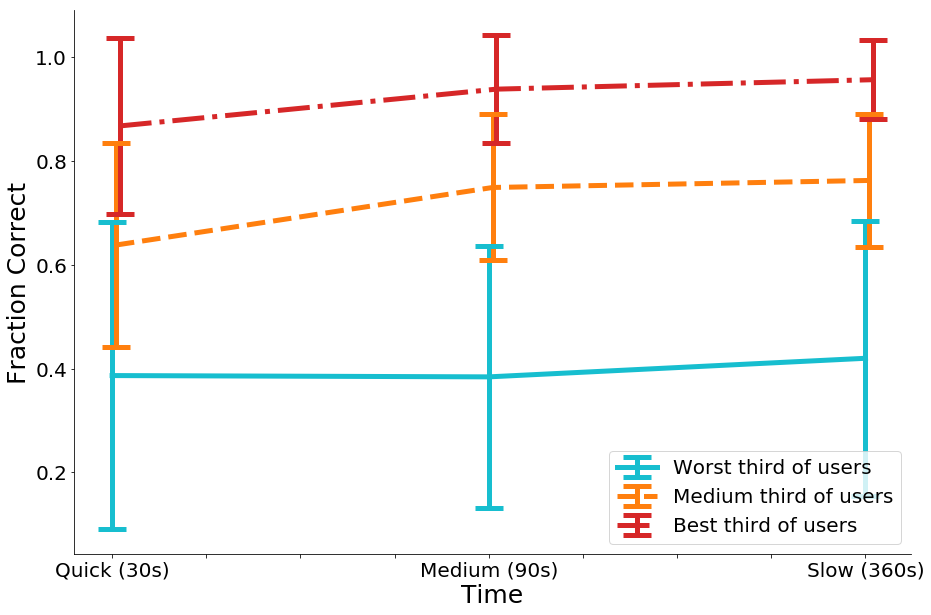

In [36]:
_ = mean_quantile_all_data(unmasked_fermi, fermi_answers)

Caption: Performance of users over time, using whole dataset for both binning and mean.


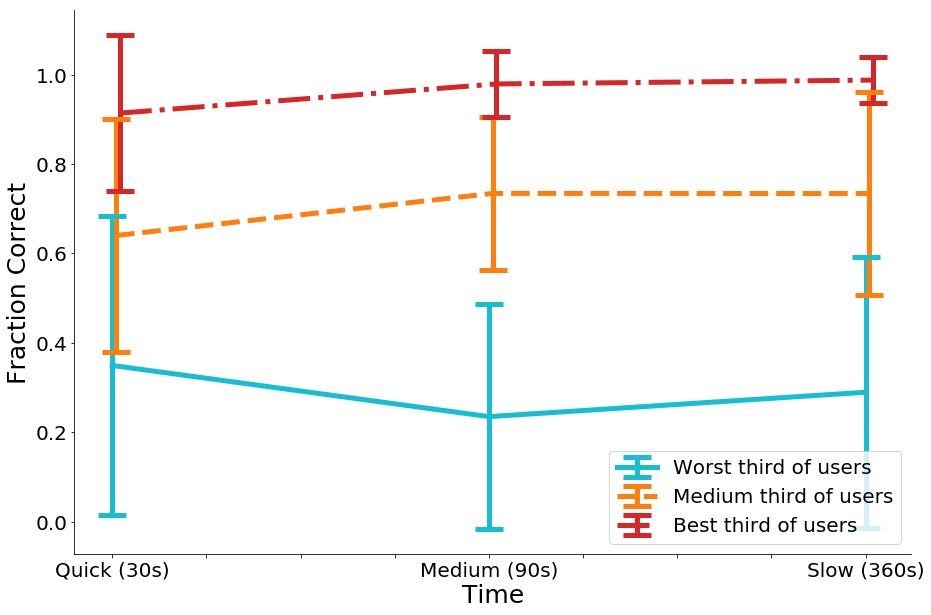

In [37]:
_ = mean_quantile_all_data(unmasked_politifact, politifact_answers)

# Standard error

Caption: Performance of users over time, using whole dataset for both binning and mean.


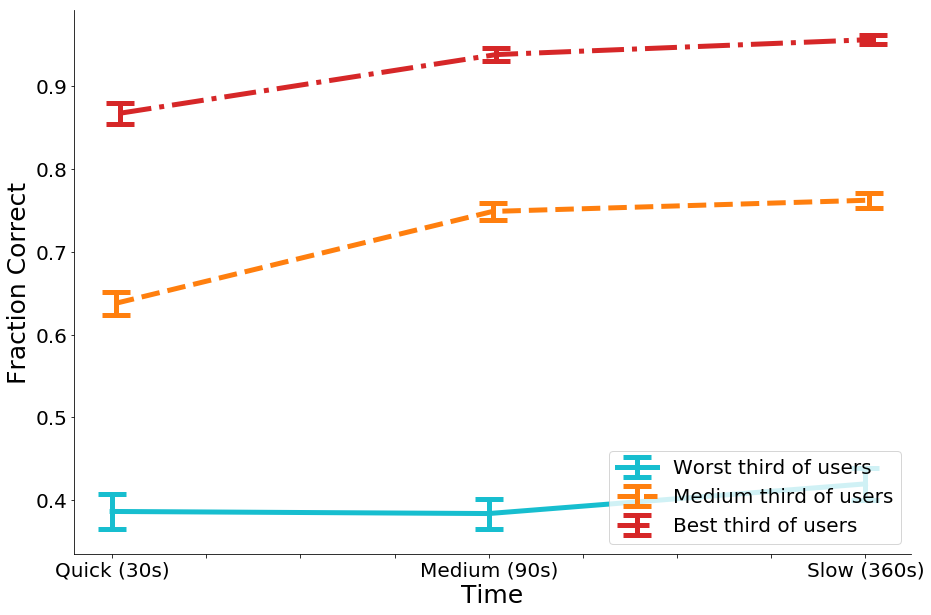

In [38]:
_ = mean_quantile_all_data(unmasked_fermi, fermi_answers, err='sem')

Caption: Performance of users over time, using whole dataset for both binning and mean.


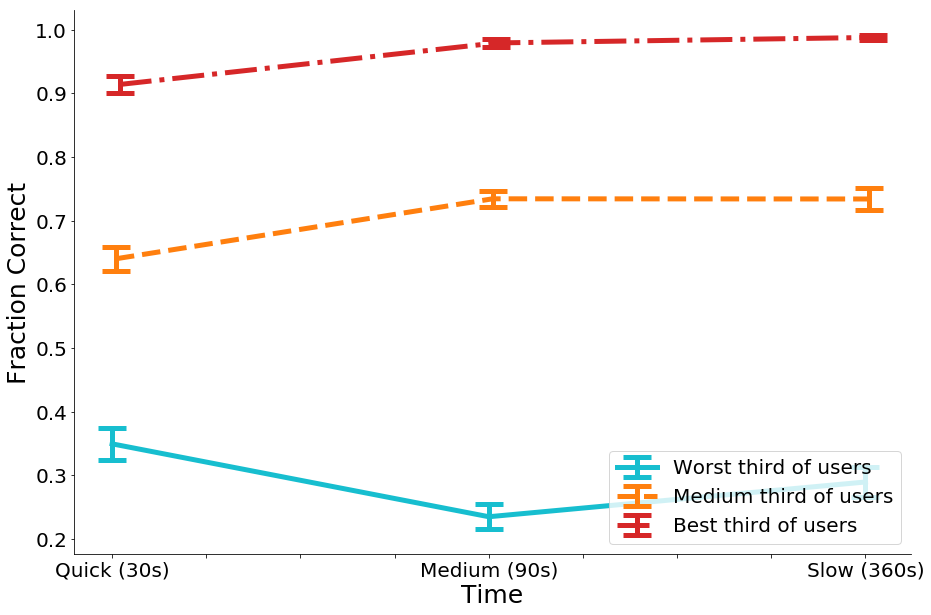

In [39]:
_ = mean_quantile_all_data(unmasked_politifact, politifact_answers, err='sem')

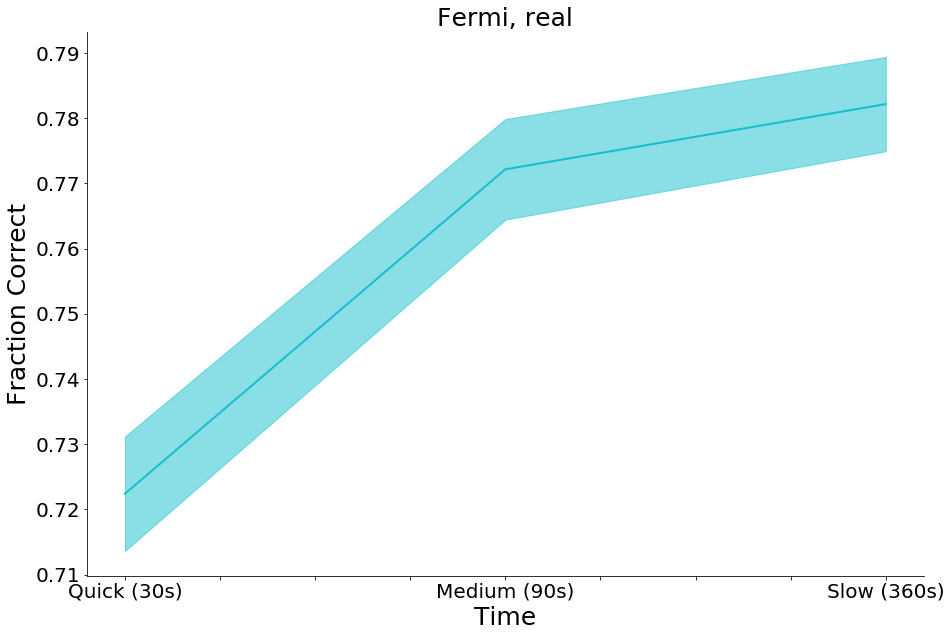

In [40]:
arr_split_time = mean_quantile_multiple_seeds(5, df = df, p= 0.5, title='Fermi, real', fil = 30, n_splits = 1, legend=False)

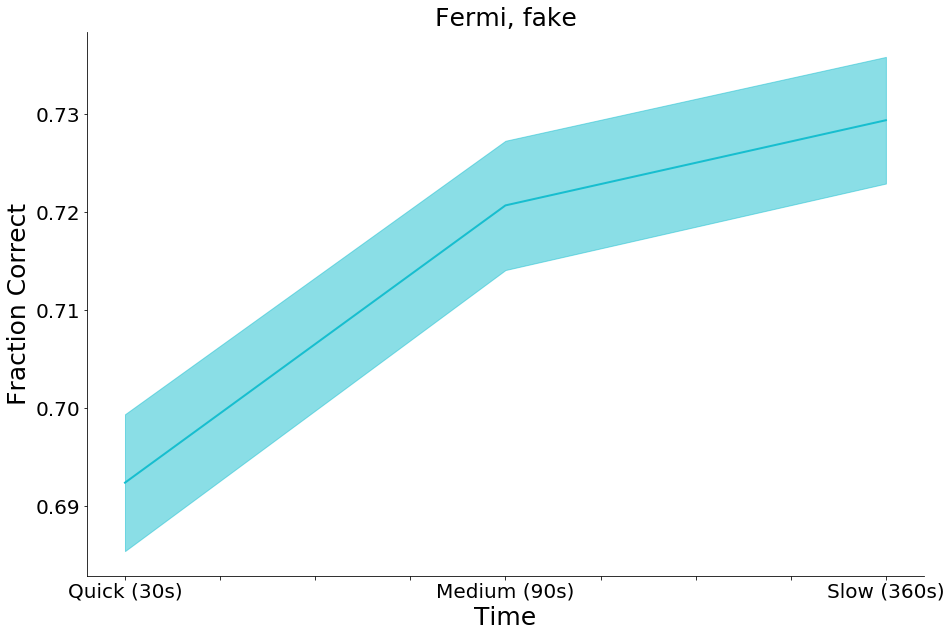

In [46]:
fake_df = make_fake_df(df)
arr_split_time = mean_quantile_multiple_seeds(5, df = fake_df, p= 0.5, title='Fermi, fake', fil = 30, n_splits = 1, legend=False)

# using half data for quantile bins and average over random seeds

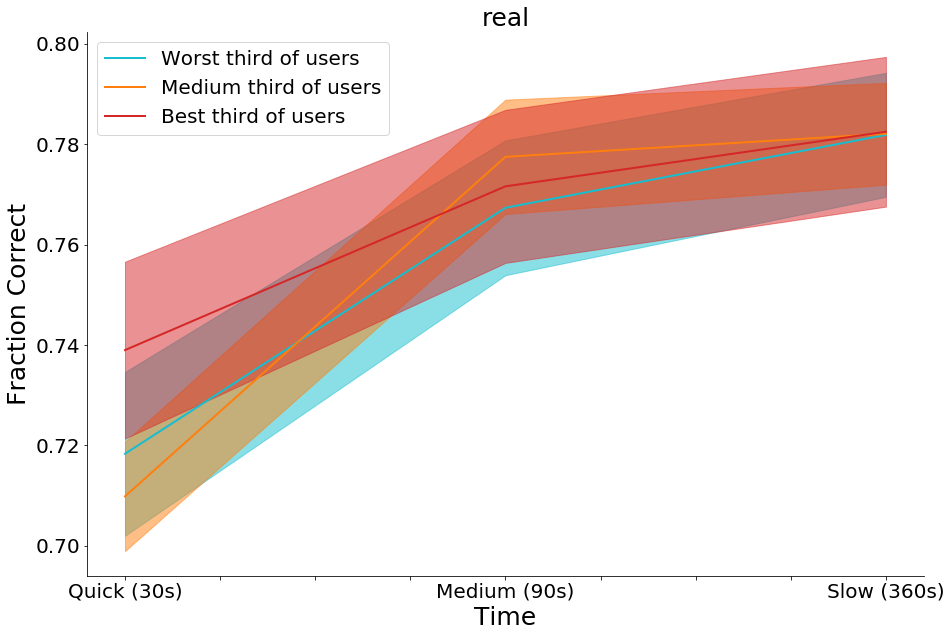

In [47]:
arr_split_time = mean_quantile_multiple_seeds(5, df = df, p= 0.5, title='real', fil = 30)

### Check against fake data:

In [48]:
fake_df.head()

,user_ids,item_ids,answer,responses,correct
0,1,3,True,"[0.14, 0.39, 0.51]",1
1,1,4,False,"[0.91, 0.94, 0.95]",0
2,1,5,False,"[0.0, 0.0, 0.0]",1
3,1,7,False,"[0.0, 0.0, 0.0]",1
4,1,9,False,"[0.0, 0.0, 0.0]",1


In [49]:
df.head()

,user_ids,item_ids,answer,responses
0,1,3,True,"[0.95, 1.0, 1.0]"
1,1,4,False,"[0.05, 0.0, 0.0]"
2,1,5,False,"[0.0, nan, nan]"
3,1,7,False,"[0.0, 0.0, 0.0]"
4,1,9,False,"[0.0, 0.0, 0.0]"


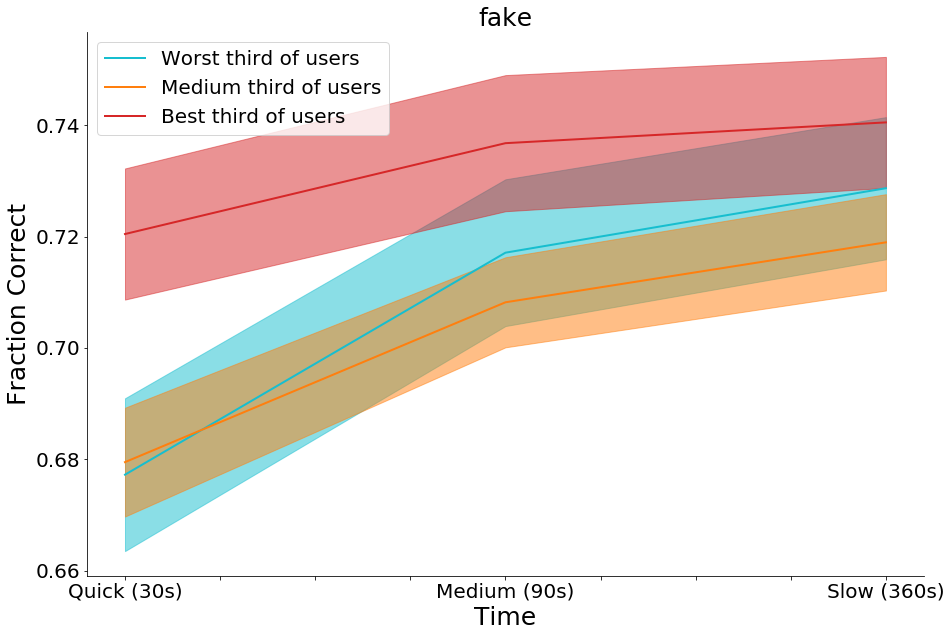

In [50]:
arr_split_time = mean_quantile_multiple_seeds(5, df =fake_df, p= 0.5, title='fake', fil = 30)

# 1.2 How predictive are fast/medium judgments

/home/ryan/anaconda3/envs/psj/lib/python3.5/site-packages/ipykernel_launcher.py:83: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Correlation coefficient was 0.586, mean mse was 0.094, coefs are (0.7638505353047246, 0.11740996354627242)
Using predict_fast, got total val score 0.132


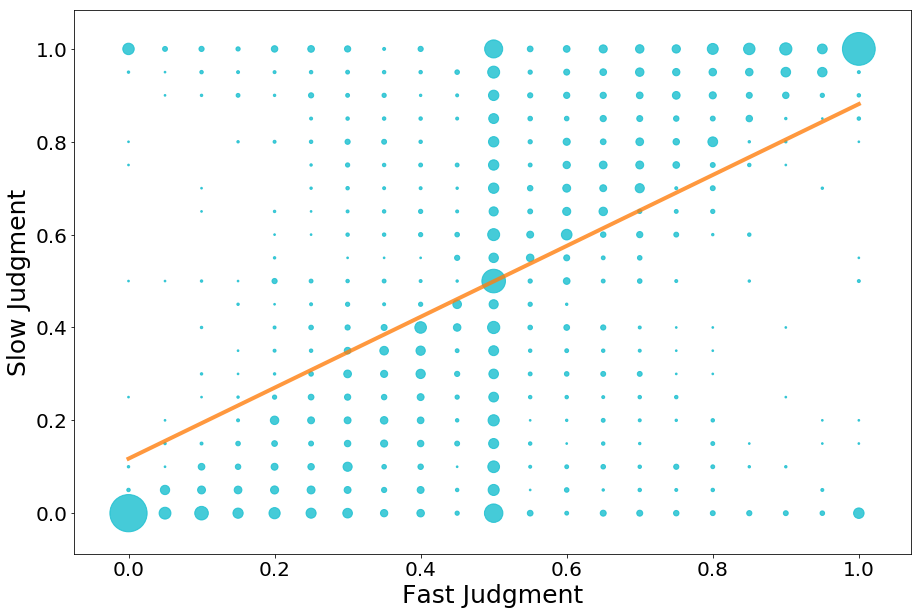

In [51]:
make_time_correlation_plot(unmasked_fermi, unmasked_fermi_val, x='fast')

/home/ryan/anaconda3/envs/psj/lib/python3.5/site-packages/ipykernel_launcher.py:83: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Correlation coefficient was 0.904, mean mse was 0.026, coefs are (0.9531835194047912, 0.02540648778941129)
Using predict_fast, got total val score 0.132


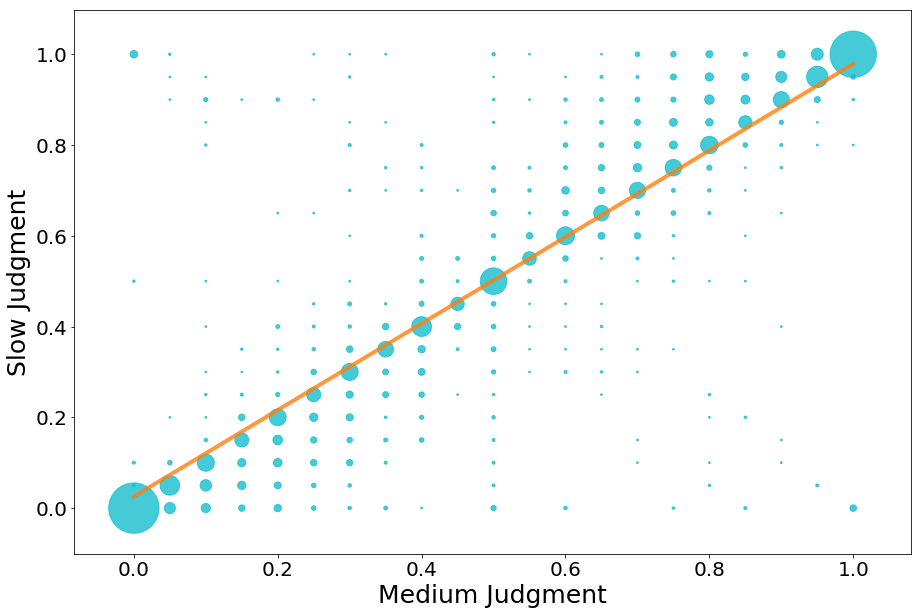

In [52]:
make_time_correlation_plot(unmasked_fermi, unmasked_fermi_val, x='medium')

/home/ryan/anaconda3/envs/psj/lib/python3.5/site-packages/ipykernel_launcher.py:83: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Correlation coefficient was 0.658, mean mse was 0.078, coefs are (0.8567452821165576, 0.06461037372945305)
Using predict_fast, got total val score 0.121


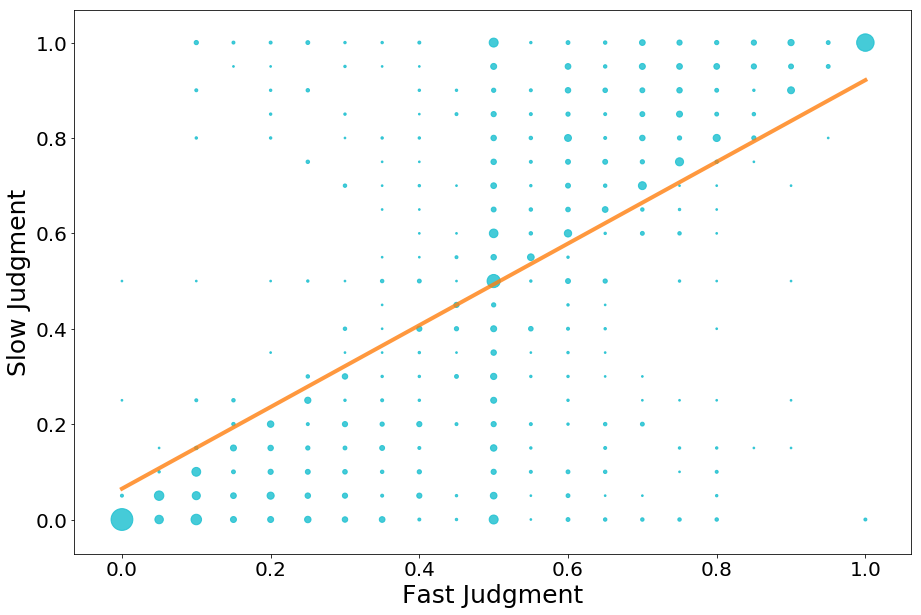

In [53]:
make_time_correlation_plot(unmasked_politifact, unmasked_politifact_val, x='fast')

/home/ryan/anaconda3/envs/psj/lib/python3.5/site-packages/ipykernel_launcher.py:83: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Correlation coefficient was 0.877, mean mse was 0.032, coefs are (0.9484158415014198, 0.01985011359081207)
Using predict_fast, got total val score 0.121


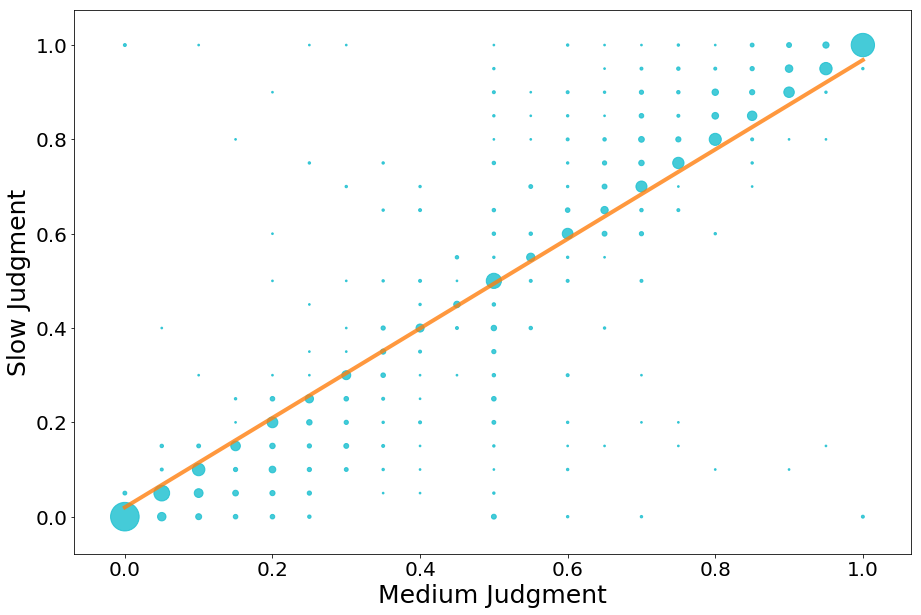

In [54]:
make_time_correlation_plot(unmasked_politifact, unmasked_politifact_val, x='medium')

# 1.3 People vary in their judgments

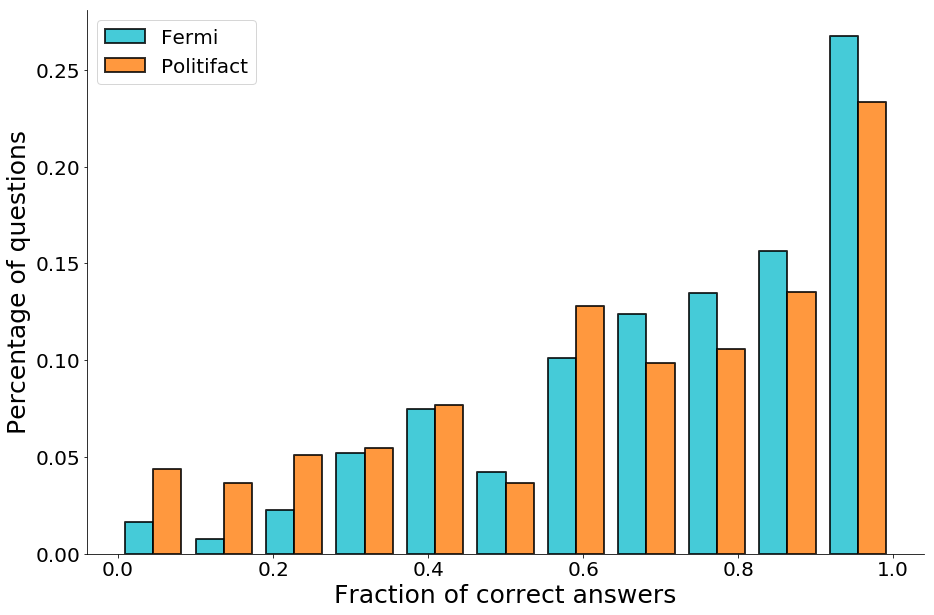

In [55]:
fraction_correct_vs_no_question(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers)

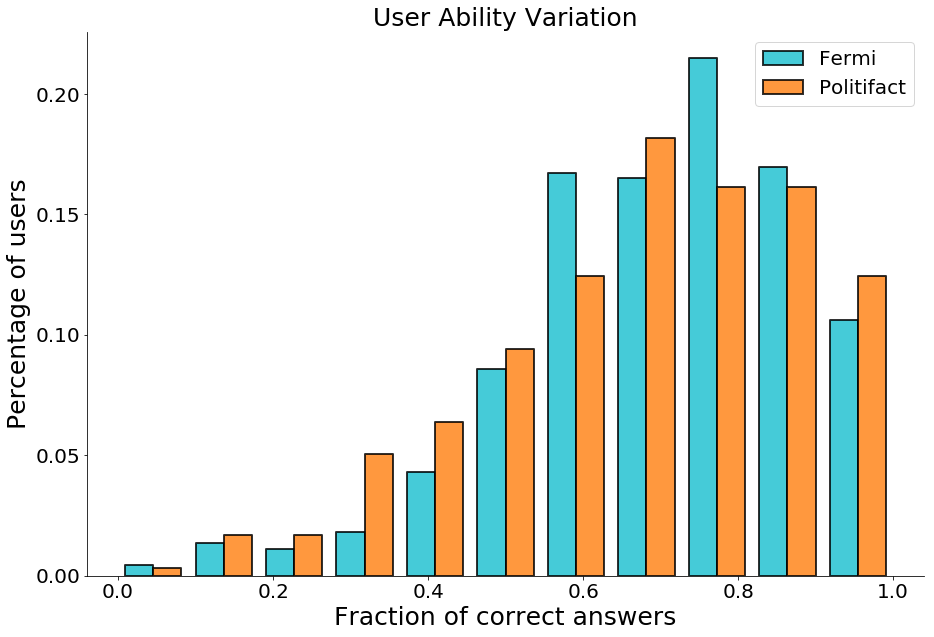

In [56]:
fraction_correct_vs_no_users(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers)

### check vs fake data

0.7326332446455583
[0.4516129  0.47772657 0.50384025 0.52995392 0.55606759 0.58218126
 0.60829493 0.6344086  0.66052227 0.68663594 0.71274962 0.73886329
 0.76497696 0.79109063 0.8172043  0.84331797 0.86943164 0.89554531
 0.92165899 0.94777266 0.97388633 1.        ]


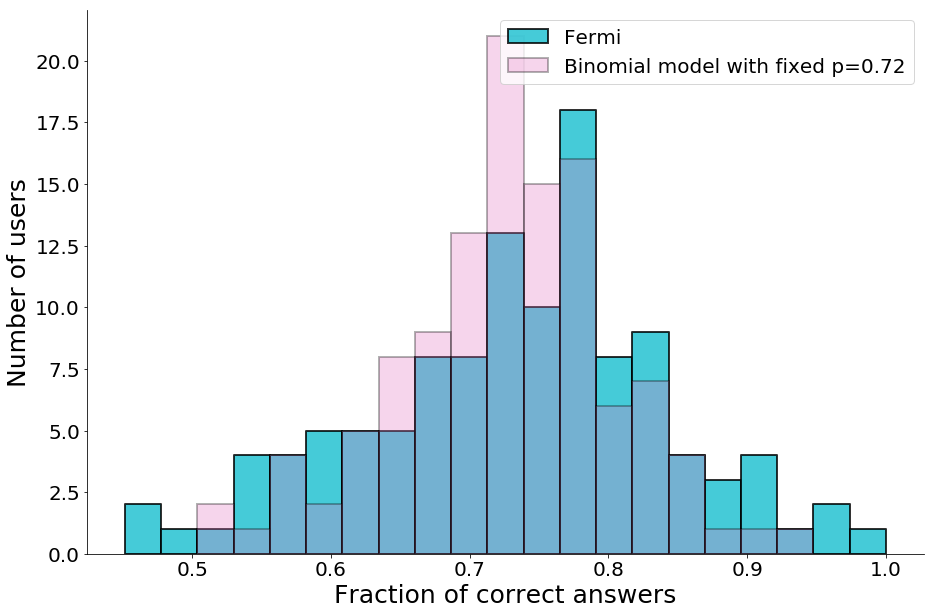

In [57]:
fraction_correct_real_fake(unmasked_fermi, unmasked_politifact, fermi_answers, politifact_answers)

See it's pretty similar to one kind of user - binomial.

# MSE vs questions

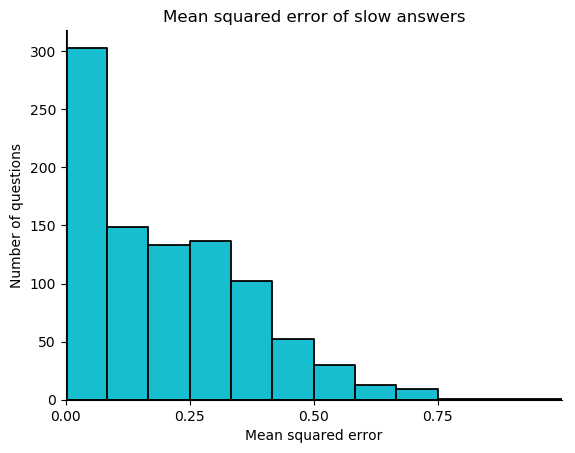

In [58]:
mse_vs_questions(unmasked_fermi, fermi_answers)

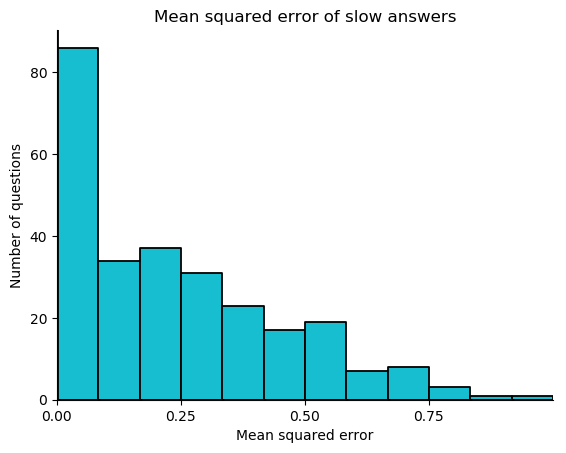

In [59]:
mse_vs_questions(unmasked_politifact, politifact_answers)

# MSE vs users

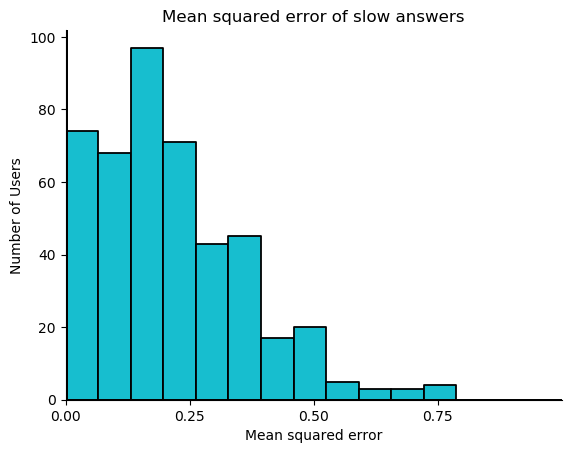

In [60]:
mse_vs_users(unmasked_fermi, fermi_answers)

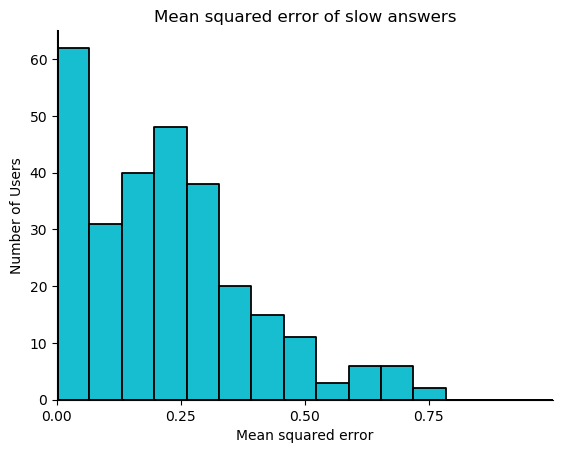

In [61]:
mse_vs_users(unmasked_politifact, politifact_answers)

# Evolving in time

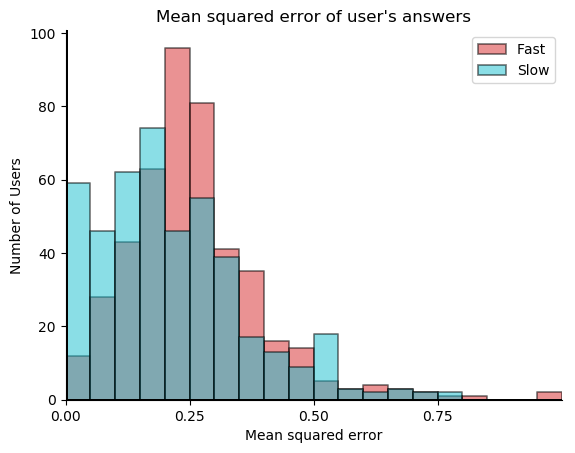

In [62]:
mse_vs_users_time(unmasked_fermi, fermi_answers)

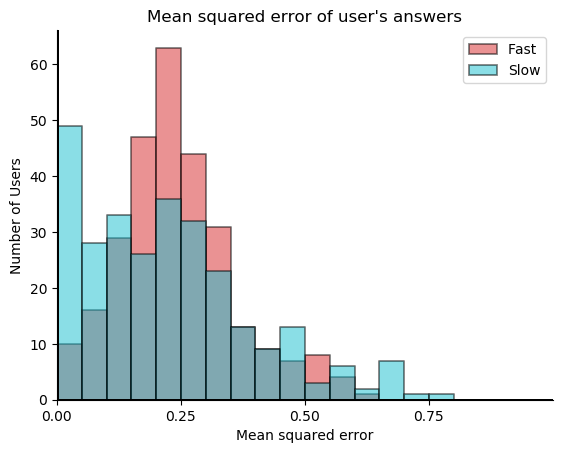

In [63]:
mse_vs_users_time(unmasked_politifact, politifact_answers)

### Compare to Fake data

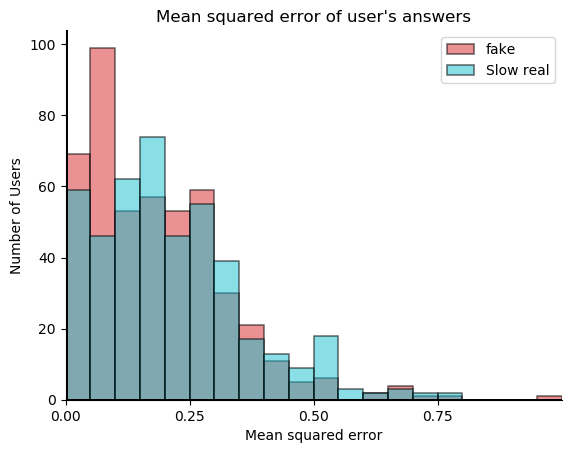

In [64]:
MSE_vs_users_real_fake(unmasked_fermi, fermi_answers)

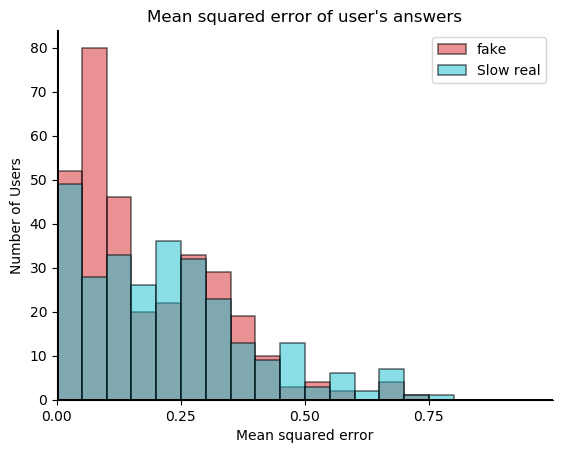

In [65]:
MSE_vs_users_real_fake(unmasked_politifact, politifact_answers)

This is also quite easy to fake.

# 1.6 How calibrated are users

## Politifact

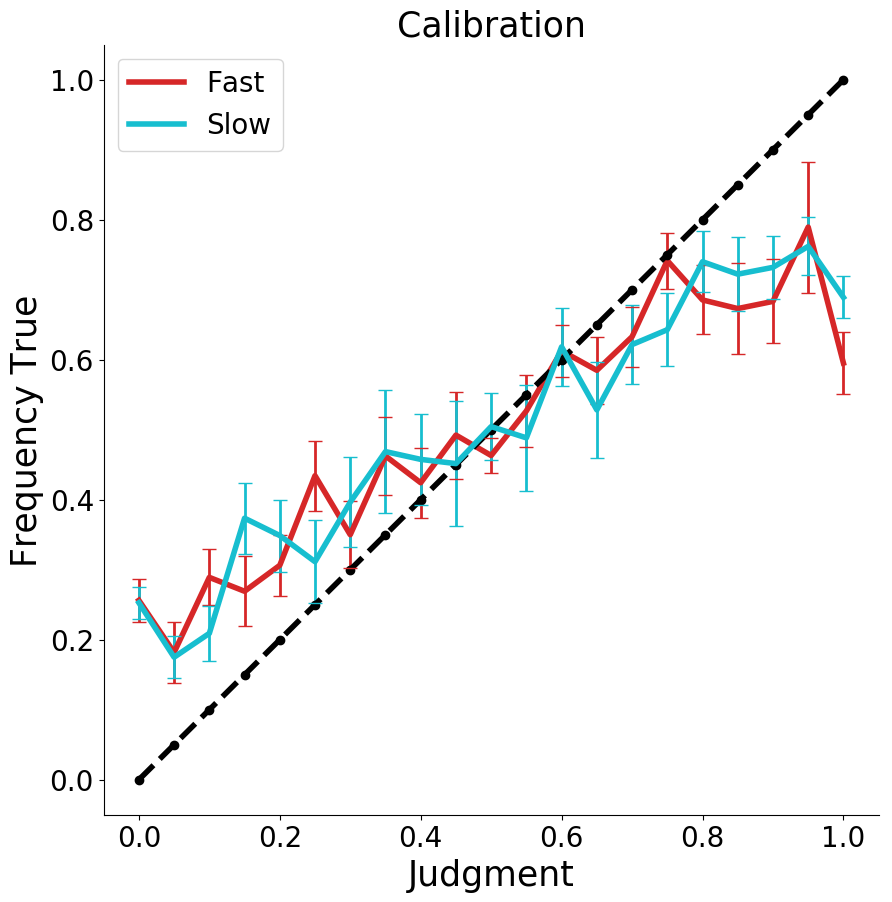

In [66]:
make_calibration(unmasked_politifact, politifact_answers)

## Fermi

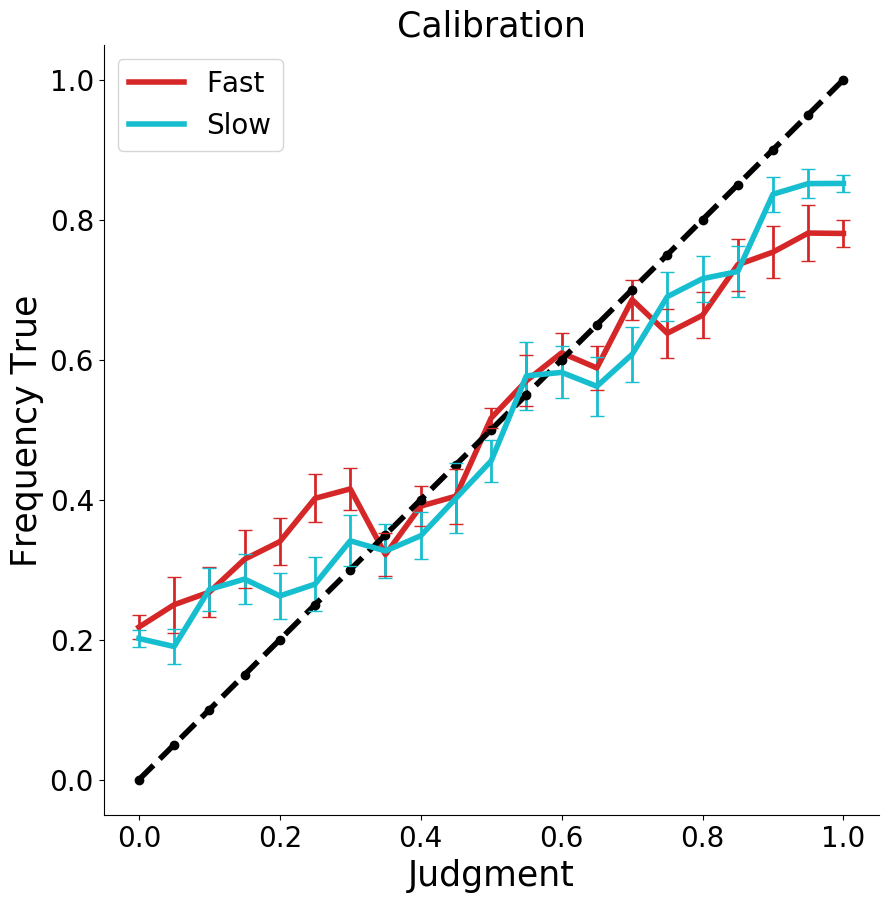

In [67]:
make_calibration(unmasked_fermi, fermi_answers)